## Hands on lecture: train TFL net

 In this hands-on lecture, we will train a model for predicting Traffic-light (TFL) in image patches, you will use the data generated in previous course to this end.
 You will :
 1. Evaluate the data previously generated and ensure it's validity.
 2. Train a CNN 
 3. Evaluate results of the trained model.
 4. seek ways to improve results

In [1]:
%reload_ext autoreload
%autoreload 2
%autosave 120
%matplotlib inline
import keras
import numpy as np, matplotlib.pyplot as plt
from os.path import join

Autosaving every 120 seconds


Using TensorFlow backend.


## Step 1. Validate your data
    use the example in the cell below, to verify the TFL patch you've generated is sane.
    Things to watch for:
    1. You are able to load and vizualize your train and val data, using the functions below.
    2. using the vizualization verify  image <--> label correspondence is correct.
    3. % Negative vs. Positive examples is aprroximately 50%
 

val :  (582, 81, 81, 3) 0/1 split 50.0 %
train :  (3316, 81, 81, 3) 0/1 split 50.0 %


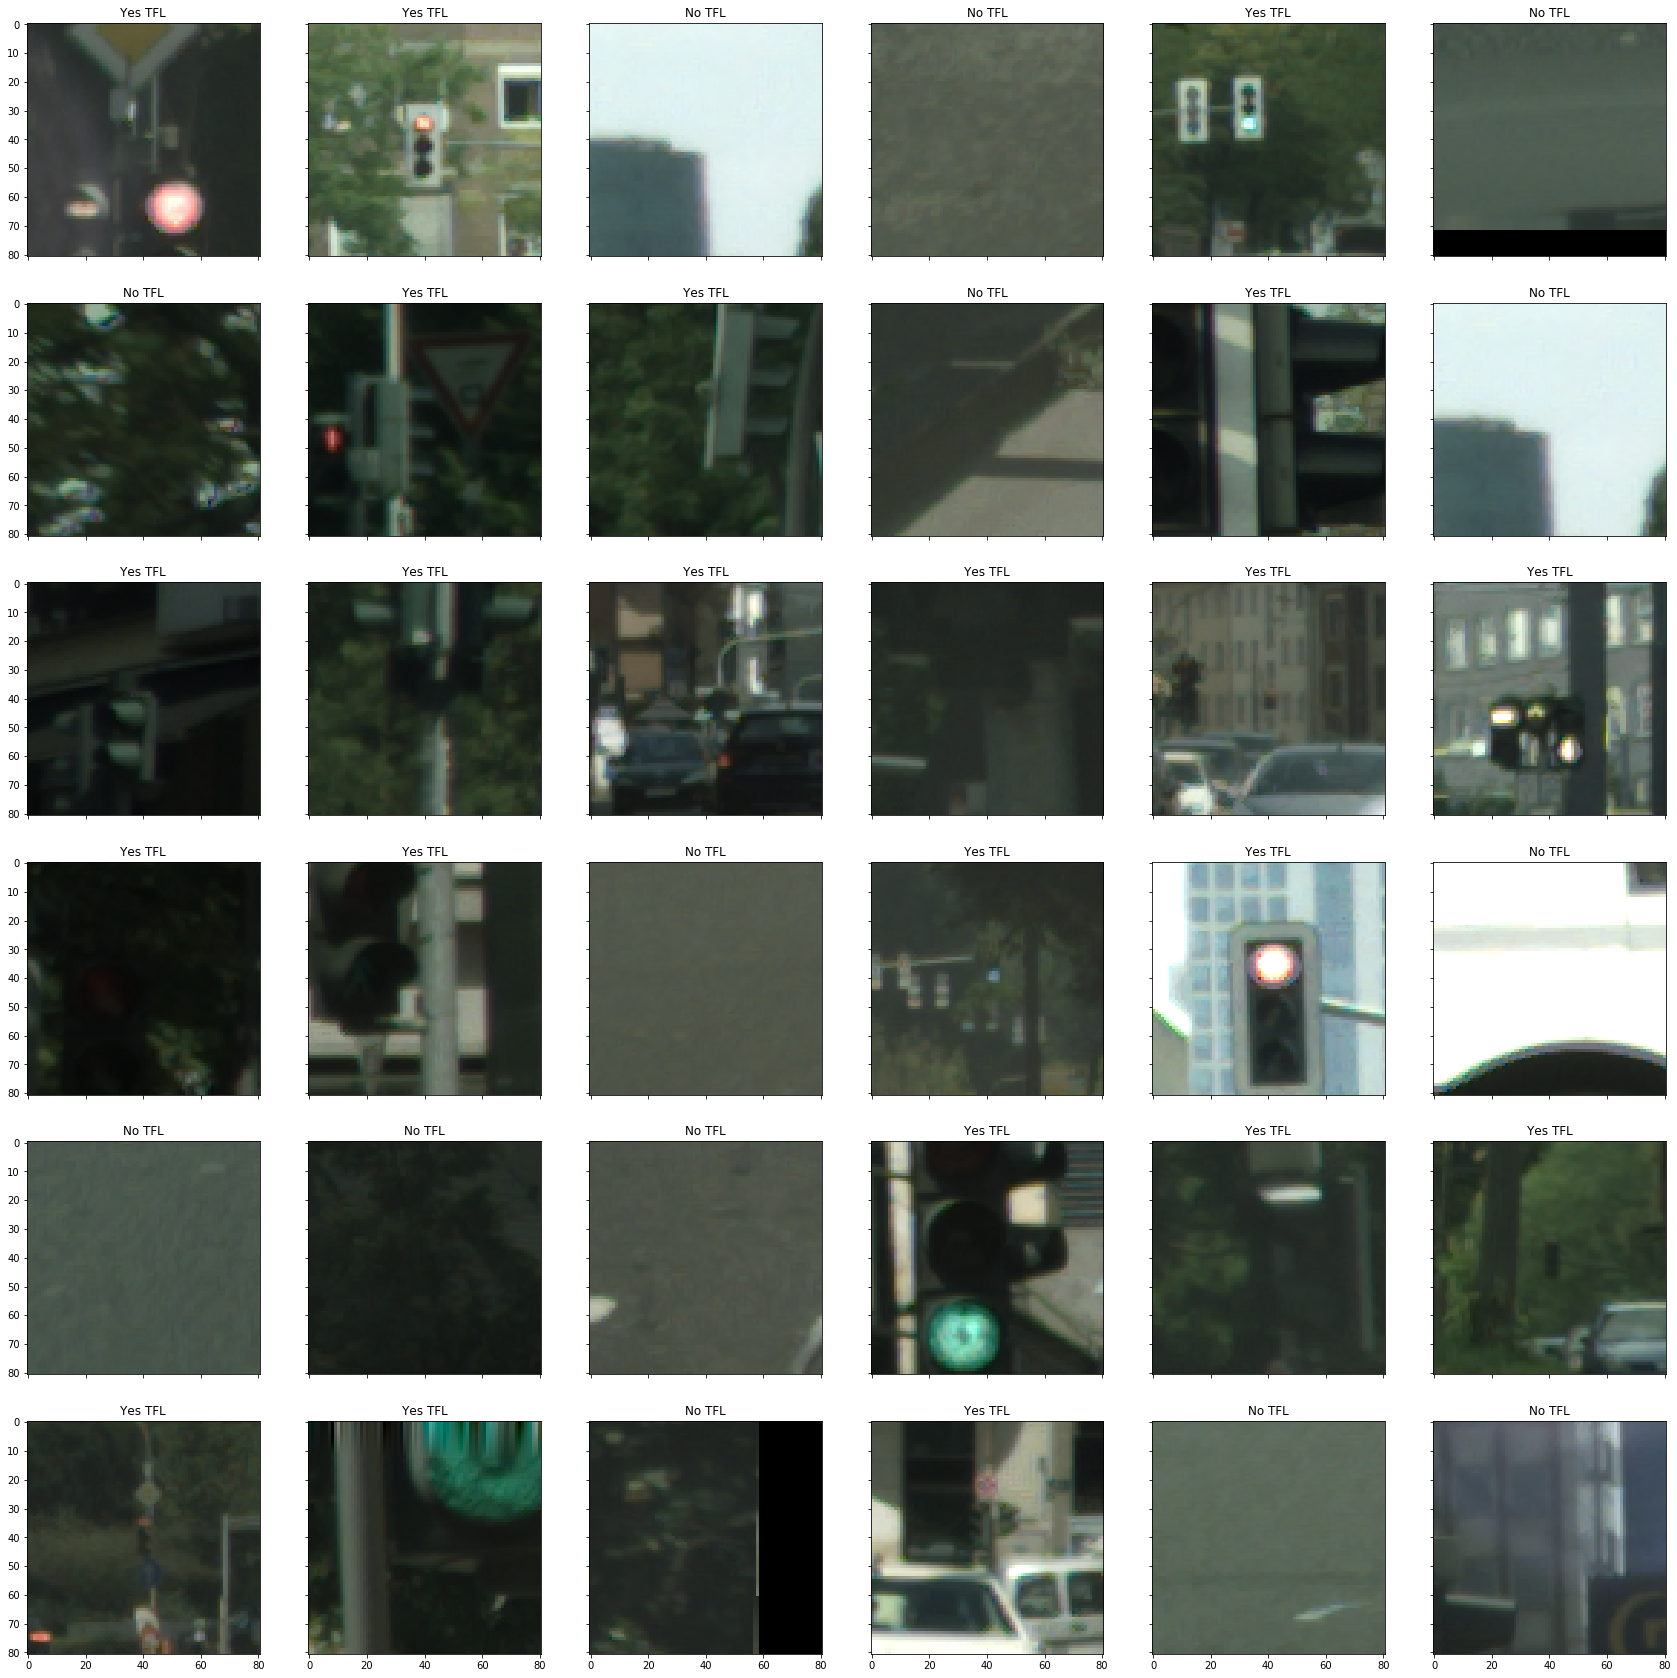

In [2]:
def load_tfl_data(data_dir, crop_shape=(81,81)):
    images = np.memmap(join(data_dir,'data.bin'),mode='r',dtype=np.uint8).reshape([-1]+list(crop_shape) +[3])
    labels = np.memmap(join(data_dir,'labels.bin'),mode='r',dtype=np.uint8)
    return {'images':images,'labels':labels}

def viz_my_data(images,labels, predictions=None, num=(5,5), labels2name= {0:'No TFL',1:'Yes TFL'}):
    assert images.shape[0] == labels.shape[0]
    assert predictions is None or predictions.shape[0] == images.shape[0]
    h = 5
    n = num[0]*num[1]
    ax = plt.subplots(num[0],num[1],figsize=(h*num[0],h*num[1]),gridspec_kw={'wspace':0.05},squeeze=False,sharex=True,sharey=True)[1]#.flatten()
    idxs = np.random.randint(0,images.shape[0],n)
    for i,idx in enumerate(idxs):
        ax.flatten()[i].imshow(images[idx])
        title = labels2name[labels[idx]]
        if predictions is not None : title += ' Prediction: {}'.format(labels2name[predictions[idx]])
        ax.flatten()[i].set_title(title)
    

root = './'  #this is the root for your val and train datasets
datasets = {
    'val':load_tfl_data(join(root,'val')),
    'train': load_tfl_data(join(root,'train')),
    }
for k,v in datasets.items():
    
    print ('{} :  {} 0/1 split {:.1f} %'.format(k,v['images'].shape, np.mean(v['labels']==1)*100))

viz_my_data(num=(6,6),**datasets['val'])   

## define the model used for training


In [3]:
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Activation,MaxPooling2D,BatchNormalization,Activation
from keras.layers.convolutional import Conv2D

def tfl_model():
    input_shape =(81,81,3)
    
    model = Sequential()
    def conv_bn_relu(filters,**conv_kw):
        model.add(Conv2D(filters,  use_bias=False, kernel_initializer='he_normal',**conv_kw))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    def dense_bn_relu(units):
        model.add(Dense(units, use_bias=False,kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    
    def spatial_layer(count, filters): 
        for i in range(count):
            conv_bn_relu(filters,kernel_size=(3,3))
        conv_bn_relu(filters, kernel_size=(3,3),strides=(2,2))
    
    conv_bn_relu(32,kernel_size=(3,3),input_shape=input_shape)
    spatial_layer(1,32) 
    spatial_layer(2,64)
    spatial_layer(2,96) 
    
    
    model.add(Flatten())
    dense_bn_relu(96)
    model.add(Dense(2, activation='softmax'))
    return model
m = tfl_model()
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 79, 79, 32)        864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 79, 79, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 77, 32)        9216      
_________________________________________________________________
batch_normalization_2 (Batch (None, 77, 77, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 77, 77, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 38, 32)       

## train

In [4]:
from keras.losses import sparse_categorical_crossentropy
root = './'
datasets = {
    'val':load_tfl_data(join(root,'val')),
    'train': load_tfl_data(join(root,'train')),
    }
#prepare our model
m = tfl_model()
m.compile(optimizer=keras.optimizers.Adam(),loss =sparse_categorical_crossentropy,metrics=['accuracy'])

train,val = datasets['train'],datasets['val']
#train it, the model uses the 'train' dataset for learning. We evaluate the "goodness" of the model, by predicting the label of the images in the val dataset.
history=m.fit(train['images'],train['labels'],validation_data=(val['images'],val['labels']),epochs = 10)

Train on 3316 samples, validate on 582 samples
Epoch 1/10
3316/3316 [==============================] - 120s 36ms/step - loss: 0.4861 - accuracy: 0.7708 - val_loss: 0.8290 - val_accuracy: 0.6649
Epoch 2/10
3316/3316 [==============================] - 123s 37ms/step - loss: 0.3538 - accuracy: 0.8450 - val_loss: 0.5778 - val_accuracy: 0.7199
Epoch 3/10
3316/3316 [==============================] - 123s 37ms/step - loss: 0.3249 - accuracy: 0.8559 - val_loss: 0.9010 - val_accuracy: 0.7491
Epoch 4/10
3316/3316 [==============================] - 122s 37ms/step - loss: 0.2785 - accuracy: 0.8833 - val_loss: 0.4265 - val_accuracy: 0.8385
Epoch 5/10
3316/3316 [==============================] - 119s 36ms/step - loss: 0.2177 - accuracy: 0.9119 - val_loss: 0.3564 - val_accuracy: 0.8625
Epoch 6/10
3316/3316 [==============================] - 121s 36ms/step - loss: 0.2110 - accuracy: 0.9144 - val_loss: 0.5850 - val_accuracy: 0.8127
Epoch 7/10
3316/3316 [==============================] - 119s 36ms/step 

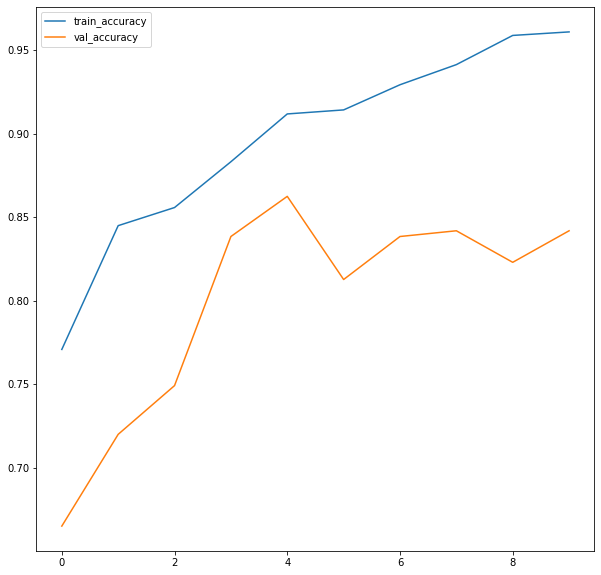

In [5]:
#compare train vs val acccuracy, 
# why is val_accuracy not as good as train accuracy? are we overfitting?
epochs = history.history
epochs['train_accuracy'] = epochs['accuracy']
plt.figure(figsize=(10,10))
for k in ['train_accuracy','val_accuracy']:
    plt.plot(range(len(epochs[k])), epochs[k],label=k)

plt.legend();

## evaluate and predict
Now thet we have a model we can use to predict results on the validation dataset.
1. What can say about example that fail prediction? can we find patterns that are common for failure cases?

accuracy: 0.8419243986254296


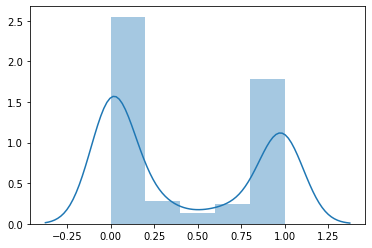

In [7]:
import seaborn as sbn
predictions = m.predict(val['images'])
sbn.distplot(predictions[:,0]);

predicted_label = np.argmax(predictions, axis=-1)
print ('accuracy:', np.mean(predicted_label==val['labels']))

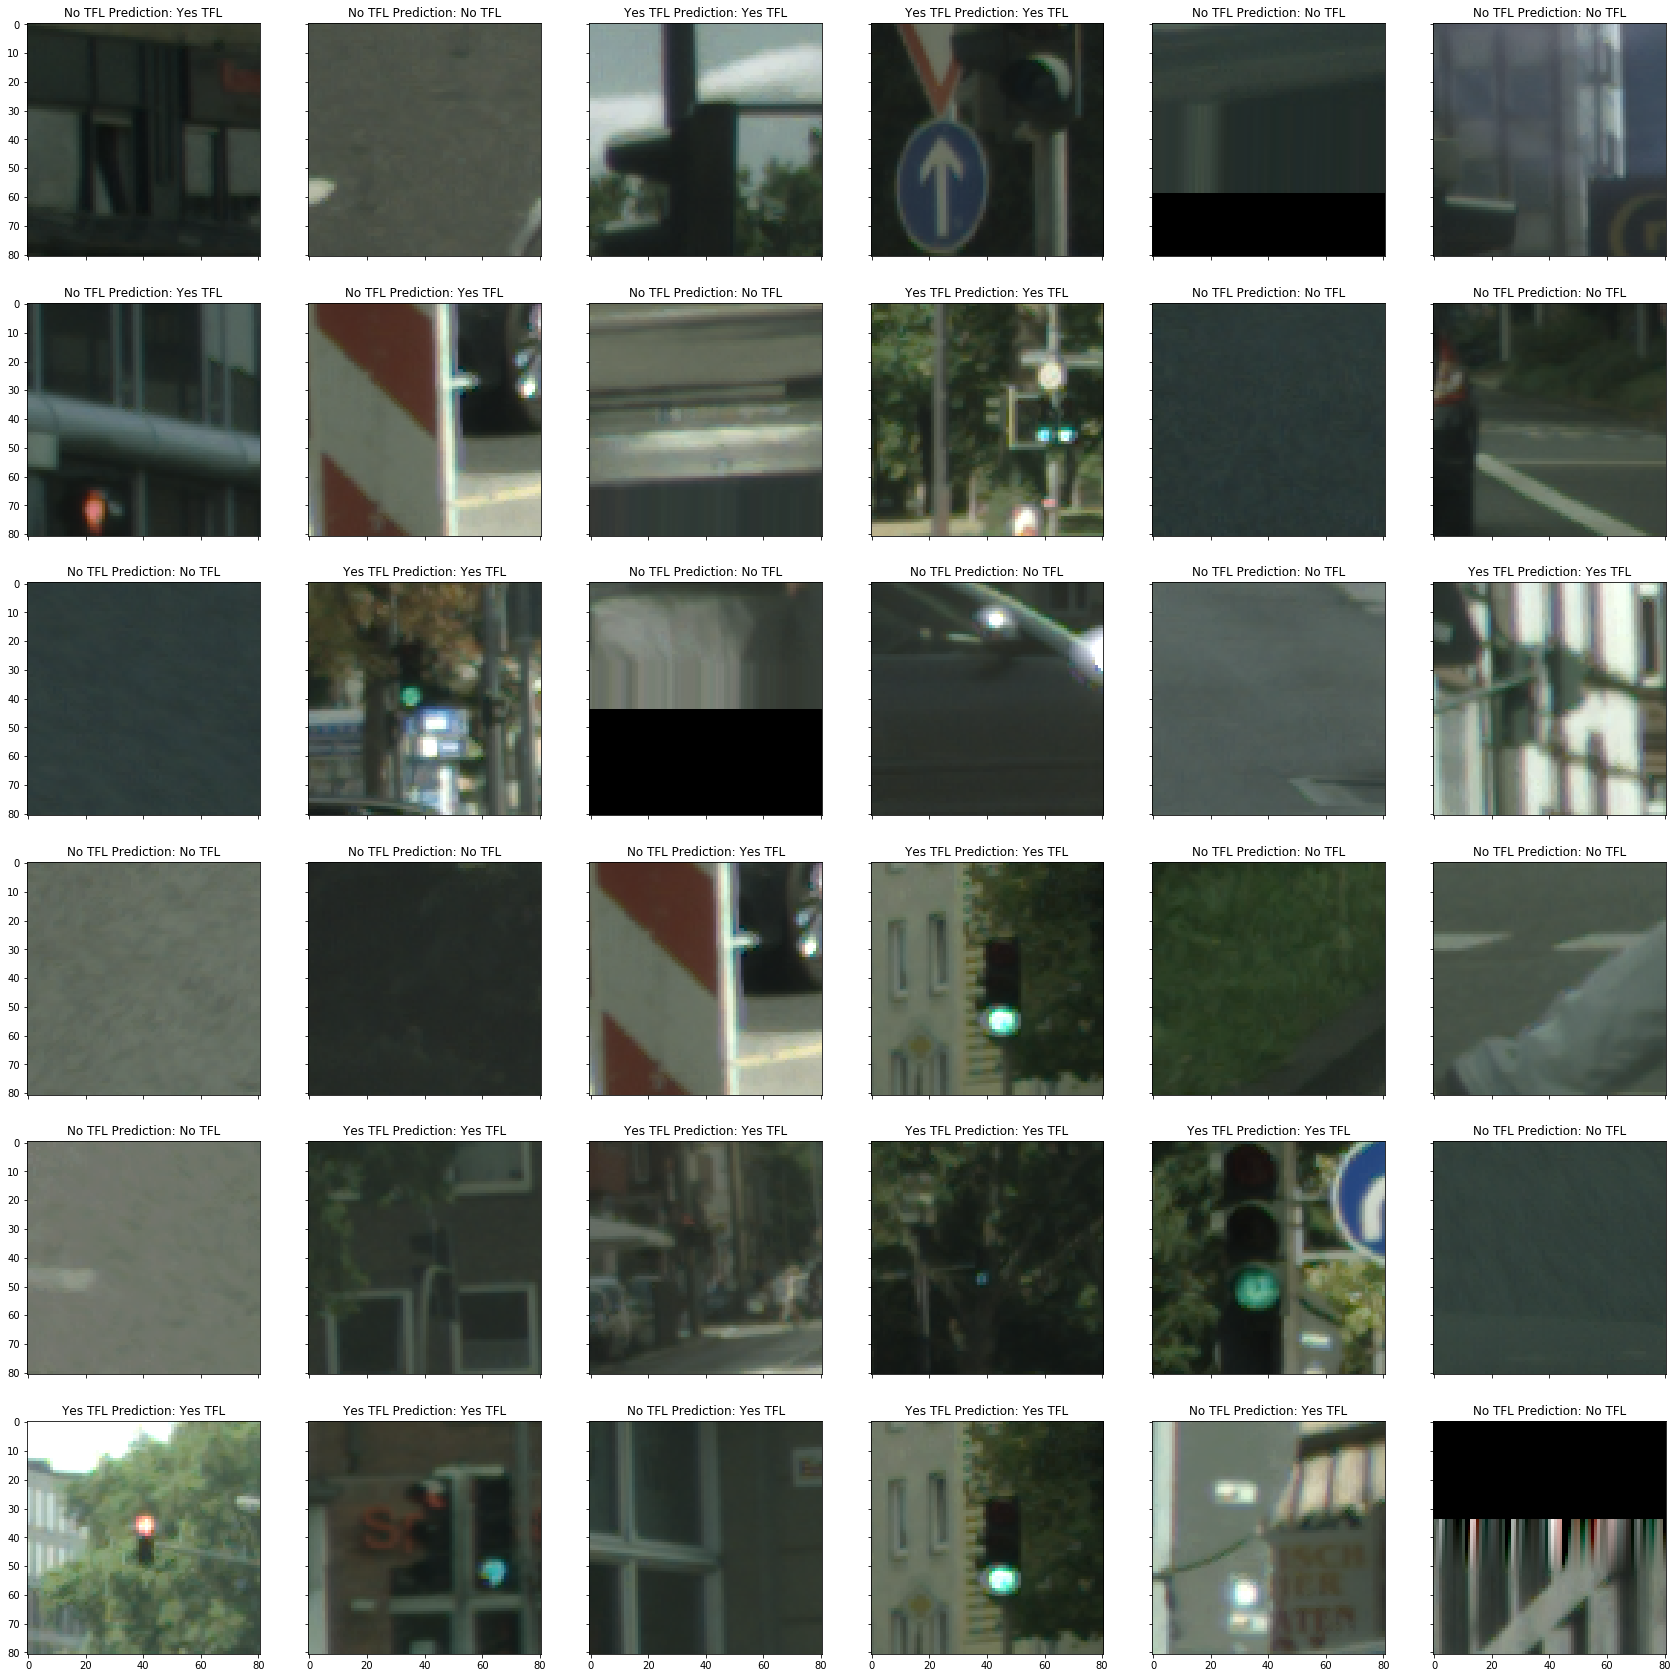

In [8]:
viz_my_data(num=(6,6),predictions=predicted_label,**val);

### Seek ways to improve resutls 
1. Try to play with diffferent models , increase / decrease the number of conv layers or number of  filters. you'll need to find a balanced model that is sufficiently large but minimzes overfit
    - try to enable tensorboard vizualization (see keras/ tensorboard doc) to help you carry the analysis
2. Data augmentation: feed your network with more examples by using data augmentation techniques: such as horizontal image flip, noise, etc

In [10]:
datasets['train']['images'].shape

(3316, 81, 81, 3)